- W207 - Fall 2021 Applied Machine Learning
- Title : Robo-Advisor For peer-to-peer lending
- Professor: John Santerre
- Team Name - Z3
- Sushant(sushant.joshi@ischool.berkeley.edu), Kris(krislee@ischool.berkeley.edu) , Haile(haile@ischool.berkeley.edu)

# Introduction
In February 2006, Prosper company started helping people borrow thousands of dollars online from strangers using a peer-to-peer lending system. Individual investors enjoyed the returns (historical return average 5.6%) from the lending, and borrowers enjoyed similar cost advantages compared with rates at a bank or credit union. Prosper alone facilitated \$1.5 billion in Borrower Loan originations during 2020 and \$18.2 billion in Borrower Loan originations since it first launched in 2006.
 
There are many loans on the peer-to-peer lending platform that inventors need to pick to put their money on, which is time-consuming and sometimes unclear which loan to pick. To address this issue, we start building a roboadviser that automatically evaluates loans and advises investors on which loan to put their money on.

To achieve that, we build a model from historical data and use it in roboadviser application to select high-quality loans to save investors time and maximize returns.

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import collections
# Learning packages
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
# Custom python modules used for feature engineering
from encoders import Encoders
from replacenan import ReplaceNaN
from imputer import Imputer
from util import *

import warnings
warnings.filterwarnings('ignore')

#TODO
from google.colab import drive
drive._mount('/content/drive')


# This packages are needed only if you want to access TitleParser (title_parser.py) functionality 
#!pip install string-grouper
#!pip install wordsegment
#!pip install pyspellchecker
#from title_parser import TitleParser

Mounted at /content/drive


# Initial Data

We used LendingClub LLC, a peer-to-peer lending company headquartered in San Francisco, historical loan data which is hosted on [Kaggle](https://www.kaggle.com/wordsforthewise/lending-club). The historical data spans between June 2007 and December 2018.

Since the loan status outcome is also determind by the economic condition, we web scrap seasonally adjusted unemployment data from [U.S. Bureau of Labor Statistic](https://www.bls.gov/charts/state-employment-and-unemployment/state-unemployment-rates-map.htm)

In [3]:
#TODO
df = pd.read_csv('/content/drive/My Drive/207-final/lc_loans_2007_to_2018Q4.csv', engine='c')
unemployment = pd.read_csv('/content/drive/My Drive/207-final/state_unemployment.csv', engine='c')
#df = pd.read_csv('./data/imputed/lc_loans_2007_to_2018Q4.csv', engine='c', low_memory='False', warn_bad_lines=False)
#unemployment = pd.read_csv('./data/imputed/state_unemployment.csv', engine='c')
unemployment.set_index('Code', inplace=True)

# EDA

- Nubmer of Rows and Columns of Lending Club data

In [4]:
# Get the number of rows and columns
rows = len(df.axes[0])
cols = len(df.axes[1])
  
# Print the number of rows and columns
print("Number of Rows: " + str(rows))
print("Number of Columns: " + str(cols))

Number of Rows: 2260701
Number of Columns: 151


In [5]:
#Categorical Vs. Numrical
cols = df.columns
num_cols = df._get_numeric_data().columns
num_cols
cat_cols= list(set(cols) - set(num_cols))
cat_cols
len(cat_cols)
print("The number Numerical Columns: " + str(len(num_cols)))
print("The number Categorical Columns: " + str(len(cat_cols)))

The number Numerical Columns: 113
The number Categorical Columns: 38


In [6]:
# Check for Nan Value 

nan_values = df.isna()
nan_columns = nan_values.any()

columns_with_nan = df.columns[nan_columns].tolist()

print("The number Columns having Null Value: " + str(len(columns_with_nan)))

The number Columns having Null Value: 150


In [7]:
# Null Value Summary 

df2=df.isnull().sum().reset_index()
df2.columns=['column','null_counts']
df2['perc']=df2['null_counts']/len(df2)*100
df2=df2.sort_values(by='perc')

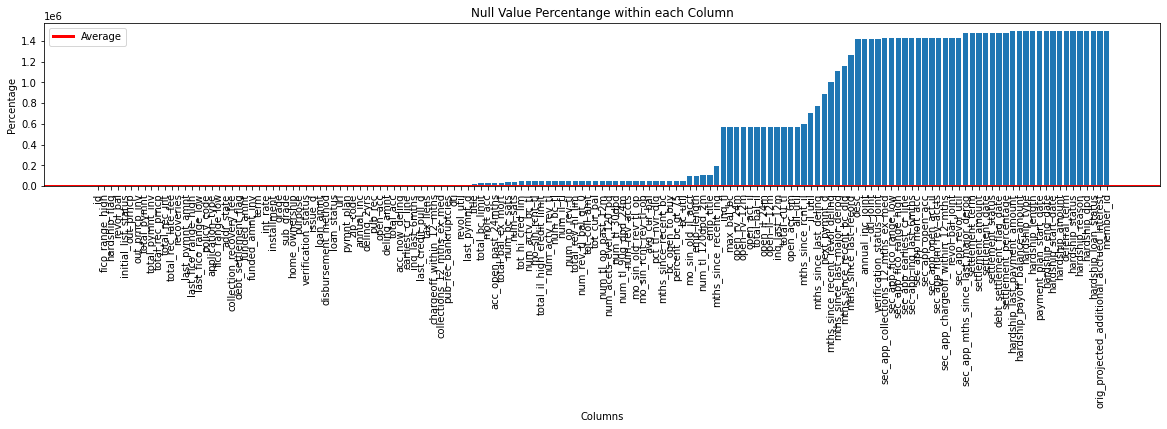

In [8]:
# Visualize the null value distribution 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
data=df2['perc'].tolist()
labels=df2['column'].tolist()
plt.figure(figsize=(20, 3))
plt.xticks(range(len(data)), labels)

plt.axhline(y=31.8, linewidth=3, color='red',label= 'Average')
plt.legend(loc = 'upper left')

plt.xlabel('Columns')
plt.ylabel('Percentage')
plt.title('Null Value Percentange within each Column')
plt.bar(range(len(data)), data) 
plt.xticks(rotation=90)
plt.show()

# Unemployment data

In [9]:
unemployment=unemployment.dropna()

In [10]:
# Get the number of rows and columns
rows = len(unemployment.axes[0])
cols = len(unemployment.axes[1])
  
# Print the number of rows and columns
print("Number of Rows: " + str(rows))
print("Number of Columns: " + str(cols))

Number of Rows: 52
Number of Columns: 173


In [11]:
#Categorical Vs. Numrical
cols = unemployment.columns
num_cols = unemployment._get_numeric_data().columns
num_cols
cat_cols= list(set(cols) - set(num_cols))
cat_cols
len(cat_cols)
print("The number Numerical Columns: " + str(len(num_cols)))
print("The number Categorical Columns: " + str(len(cat_cols)))

The number Numerical Columns: 170
The number Categorical Columns: 3


In [12]:
# Check for Nan Value 

nan_values = unemployment.isna()
nan_columns = nan_values.any()

columns_with_nan = unemployment.columns[nan_columns].tolist()

print("The number Columns having Null Value: " + str(len(columns_with_nan)))

The number Columns having Null Value: 0


In [13]:
unemployment2=unemployment['Sep-21'].reset_index()

In [14]:
unemployment2.columns=['addr_state','unemployment_status']

In [15]:
import plotly.express as px  # Be sure to import express
fig = px.choropleth(unemployment2,  # Input Pandas DataFrame
                    locations="addr_state",  # DataFrame column with locations
                    color="unemployment_status",  # DataFrame column with color values
                    locationmode = 'USA-states') # Set to plot as US States
fig.update_layout(
    title_text = 'State Heatmap', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
)
fig.show()  # Output the plot to the screen

- Null Value Status of Lending Club Data

# Target Classes
This project goal is to build a model that predicts if a given loan at the time of issue will be `Fully Paid` or `Charged Off`. For that reason, we will pick records with only `Fully Paid` and `Charged Off` loan status to extract insight and use it for prediction.

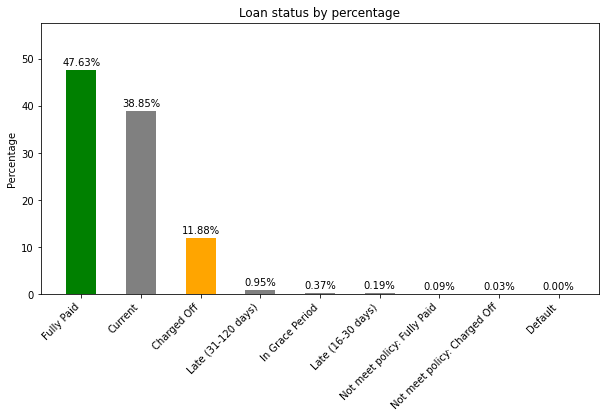

In [ ]:
def show_class_composition(df):
  """Displaying class composition for the given dataset
  Parameters
  ----------
  df : A panda dataset that has "loan_status" feature
  """
  summary = df['loan_status'].value_counts().rename_axis('unique_values').reset_index(name='counts')
  summary['percent'] = (100. * (summary['counts'] / summary['counts'].sum())).round(3)
  summary['unique_values'] = summary['unique_values'].replace(
      ['Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off'],
      ['Not meet policy: Fully Paid', 'Not meet policy: Charged Off'])
  colors = ['Green', 'gray', 'orange', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray']
  plt.rcParams["figure.figsize"] = [10, 5]
  fig, ax = plt.subplots()
  pps = ax.bar(summary['unique_values'], summary['percent'], width=0.5, align='center', color=colors)
  ax.set_ylim([0, summary['percent'].max()+10])
  plt.xticks(rotation=45, ha='right')
  # Putting percentage value on top of each bar
  for p in pps:
    y = p.get_height()
    ax.text(x=p.get_x()+p.get_width()/2, y=y+1, s="{:.2f}%".format(y), ha='center')
  ax.set_title("Loan status by percentage")
  ax.set_ylabel("Percentage")
  plt.show()

show_class_composition(df)

- Target Classes with only target variables

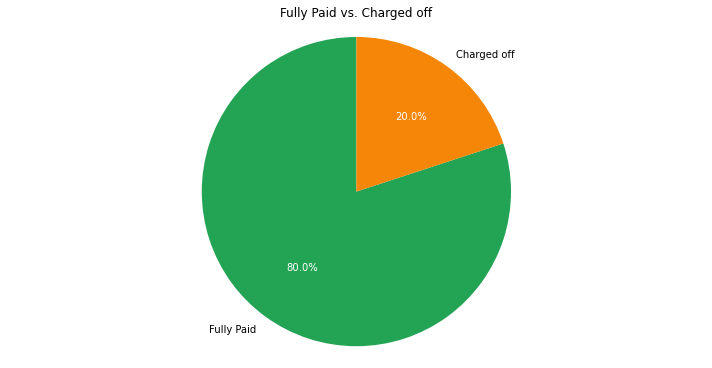

In [ ]:
#pie chart (version2)
import matplotlib.pyplot as plt
# Pie chart
labels = ['Fully Paid', 'Charged off']
sizes = [0.800374, 0.199626]
#colors
colors = ['#23a455','#f58607']

    
fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
for text in texts:
    text.set_color('Black')
for autotext in autotexts:
    autotext.set_color('White')
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Fully Paid vs. Charged off")
plt.show()

# Data cleanup for further EDA

We have 151 features out of which 19 of them are introduced on September 2012 and 14 features are introduced on January 2016. Since the feature value is NaN before the introduction of the new features, we removed all records before January 2016.

Features introduced on September 2012: `total_rev_hi_lim`, `avg_cur_bal`, `mo_sin_old_rev_tl_op`, `mo_sin_rcnt_rev_tl_op`, `mo_sin_rcnt_tl`, `num_accts_ever_120_pd`, `num_actv_bc_tl`, `num_actv_rev_tl`, `num_bc_tl`, `num_il_tl`, `num_op_rev_tl`, `num_rev_accts`, `num_rev_tl_bal_gt_0`, `num_tl_30dpd`, `num_tl_90g_dpd_24m`, `num_tl_op_past_12m`, `pct_tl_nvr_dlq`, `tot_hi_cred_lim`, and `total_il_high_credit_limit`

Features introduced on January 2016: `open_acc_6m`, `open_act_il`, `open_il_12m`, `open_il_24m`, `1-mths_since_rcnt_il`, `total_bal_il`, `open_rv_12m`, `open_rv_24m`, `max_bal_bc`, `all_util`, `inq_fi`, `total_cu_tl`, `inq_last_12m`, and `il_util`

We didn't conditue more data processing as we did in modeling part.

In [ ]:
# Initialing objects that will be used for feature engineering
encoders = Encoders()
replaceNaN = ReplaceNaN()
imputer = Imputer()
scaler = StandardScaler()
vectorizer = TfidfVectorizer(stop_words='english', max_features = 100)# min_df=0.1)
#titleParser = TitleParser()
df_records = {}
df_features = {}

df_records["Original"] = df.shape[0]
df_features["Original"] = df.shape[1]
# Removing loans other than "Fully Paid" and "Charged Off"
df_clean = remove_invalid_rows(df)
df_records["After invalid rows removed"] = df_clean.shape[0]
df_clean = convert_to_date(df_clean) # String datatype to datetime conversion
# Taking data starting from January 2016 based on the above reason
df_clean = get_data_since(df_clean, datetime.date(2016, 1, 1))

# The following three feature generators do mapping from one column to another column
df_clean = add_issue_date_feature(df_clean) # Date to integer converion
df_clean = add_unemployment_rate(unemployment, df_clean)
df_clean = months_since_earliest_cr_line(df_clean)
df_features["After generating new features"] = df_clean.shape[1]
df_clean = remove_features(df_clean)
df_records["After removing data before Jan 2016"] = df_clean.shape[0]
df_features["After removing features"] = df_clean.shape[1]

# For EDA part, we stopped prcessing before we split the data into training, dev, and test.
'''
# Splitting the data into training, dev and test
train_data, dev_data, test_data = split_data(df_clean)

# Replaces some known features NaN value with 0 value
# We performed analysis on each feature to identify which NaN represents 0
train_data = replaceNaN.fit_transform(train_data)
dev_data = replaceNaN.transform(dev_data)

# Encode categorical features
encode_features = ['home_ownership', 'verification_status', 'purpose',
                   'application_type', 'term', 'grade', 'sub_grade', 'emp_length',
                   'initial_list_status', 'disbursement_method', 'loan_status']
train_data = encoders.fit_transform(train_data, encode_features)
dev_data = encoders.transform(dev_data)
df_features["After Categorical Encoding"] = train_data.shape[1]

# Splitting into Matrix and Label
train_data, train_label = get_ML(train_data, 'loan_status=Fully Paid')
dev_data, dev_label = get_ML(dev_data, 'loan_status=Fully Paid')

# It uses KNN to impute NaN values
train_data = imputer.fit_transform(train_data)
dev_data = imputer.transform(dev_data)
#test_data = imputer.transform(test_data)


# Since regularized methods apply a penalty to the coefficients, we need to ensure our coefficients are on a common scale.
scaled_train_data = scaler.fit_transform(train_data)
scaled_dev_data = scaler.transform(dev_data)
# Converting from ndarray type to panda dataframe type
scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_dev_data = pd.DataFrame(scaled_dev_data, columns=dev_data.columns)

# min/max scaler
min_max_scaler = MinMaxScaler()
min_max_scaled_train_data = min_max_scaler.fit_transform(train_data)
min_max_scaled_dev_data = min_max_scaler.transform(dev_data)
min_max_scaled_train_data = pd.DataFrame(min_max_scaled_train_data, columns=train_data.columns)
min_max_scaled_dev_data = pd.DataFrame(min_max_scaled_dev_data, columns=dev_data.columns)'''

'\n# Splitting the data into training, dev and test\ntrain_data, dev_data, test_data = split_data(df_clean)\n\n# Replaces some known features NaN value with 0 value\n# We performed analysis on each feature to identify which NaN represents 0\ntrain_data = replaceNaN.fit_transform(train_data)\ndev_data = replaceNaN.transform(dev_data)\n\n# Encode categorical features\nencode_features = [\'home_ownership\', \'verification_status\', \'purpose\',\n                   \'application_type\', \'term\', \'grade\', \'sub_grade\', \'emp_length\',\n                   \'initial_list_status\', \'disbursement_method\', \'loan_status\']\ntrain_data = encoders.fit_transform(train_data, encode_features)\ndev_data = encoders.transform(dev_data)\ndf_features["After Categorical Encoding"] = train_data.shape[1]\n\n# Splitting into Matrix and Label\ntrain_data, train_label = get_ML(train_data, \'loan_status=Fully Paid\')\ndev_data, dev_label = get_ML(dev_data, \'loan_status=Fully Paid\')\n\n# It uses KNN to im

In [ ]:
df_clean

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,issue_year,issue_month,unemployment_rate,earliest_cr_line_months
421101,3000.0,36 months,7.34,93.10,A,A4,9 years,RENT,52000.0,Source Verified,...,0.0,191216.0,141.0,30500.0,0.0,Cash,2018,3,4.4,242
421113,5000.0,36 months,11.98,166.03,B,B5,10+ years,OWN,55000.0,Not Verified,...,0.0,61551.0,28880.0,22000.0,27751.0,Cash,2018,3,4.2,199
421120,7000.0,36 months,11.98,232.44,B,B5,< 1 year,MORTGAGE,40000.0,Verified,...,0.0,132817.0,131726.0,10000.0,118917.0,Cash,2018,3,4.0,132
421135,30000.0,36 months,21.85,1143.39,D,D5,10+ years,OWN,57000.0,Verified,...,0.0,188780.0,62252.0,29400.0,35000.0,Cash,2018,3,3.8,215
421137,21000.0,60 months,20.39,560.94,D,D4,10+ years,OWN,85000.0,Source Verified,...,0.0,172433.0,51667.0,27100.0,39733.0,Cash,2018,3,4.3,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,18000.0,60 months,9.49,377.95,B,B2,5 years,OWN,130000.0,Not Verified,...,0.0,275356.0,54349.0,13100.0,77756.0,Cash,2016,10,4.8,147
2260690,29400.0,60 months,13.99,683.94,C,C3,9 years,MORTGAGE,180792.0,Not Verified,...,0.0,719056.0,148305.0,56500.0,95702.0,Cash,2016,10,5.5,175
2260691,32000.0,60 months,14.49,752.74,C,C4,3 years,MORTGAGE,157000.0,Source Verified,...,0.0,524379.0,122872.0,15800.0,23879.0,Cash,2016,10,5.4,64
2260692,16000.0,60 months,12.79,362.34,C,C1,10+ years,RENT,150000.0,Not Verified,...,0.0,87473.0,65797.0,10100.0,73473.0,Cash,2016,10,5.1,230


# Fully Paid vs. Charged off 

It is important to compare the Fully Paid and Charge off with proper EDA. 
There are many columns to look into, but we have chosen primary aspects that we thought important to check. 


Features to check: `loan_amnt`, `Installment`, `Interest Rate`, `annual_inc`, 


In [ ]:
import seaborn as sns
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(df_clean.loc[df_clean[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df_clean[col_name], order=sorted(df_clean[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    my_pal = {'Fully Paid': "green", "Charged Off": "orange"}
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=df_clean, ax=ax2, palette=my_pal)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

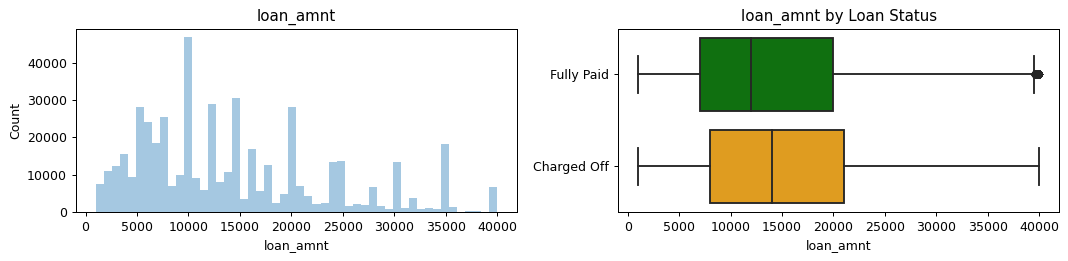

In [ ]:
plot_var('loan_amnt', 'loan_amnt', continuous=True)

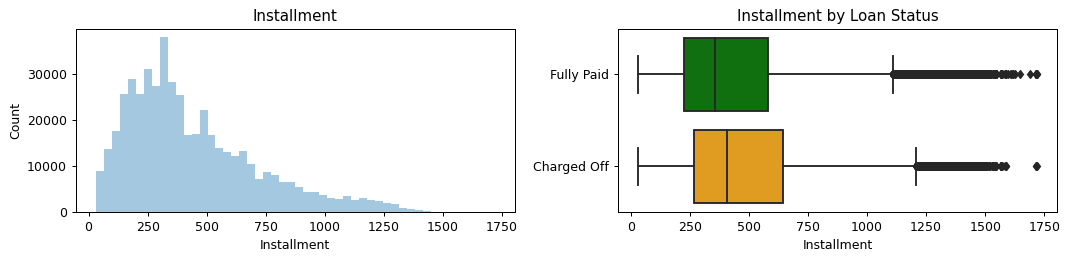

In [ ]:
plot_var('installment', 'Installment', continuous=True)

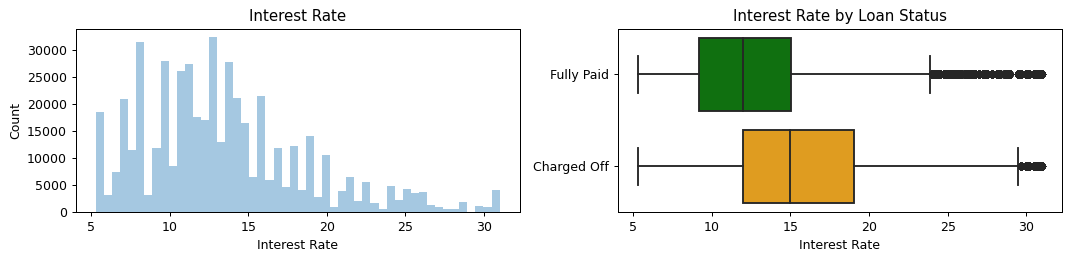

In [ ]:
plot_var('int_rate', 'Interest Rate', continuous=True)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,110795.00,4.79,0.27,0.00,4.64,4.79,4.94,6.81
Fully Paid,379514.00,4.83,0.28,0.00,4.68,4.83,4.98,7.04


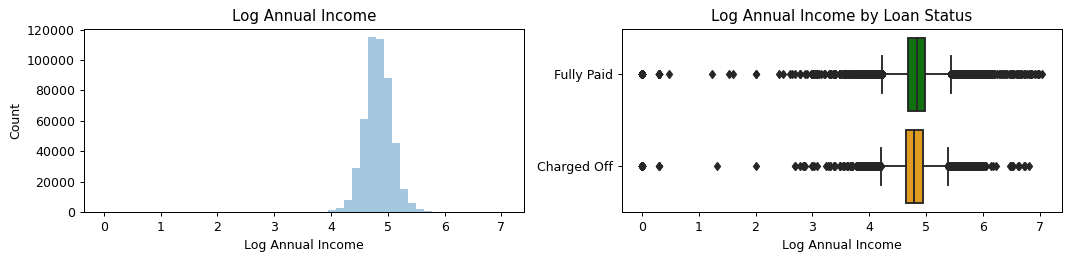

In [ ]:
df_clean['log_annual_inc'] = df_clean['annual_inc'].apply(lambda x: np.log10(x+1))
df_clean['log_annual_inc'].describe()
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)
df_clean.groupby('loan_status')['log_annual_inc'].describe()

# Fully Paid vs. Charged off : Purpose 

In [ ]:
pur1=df_clean[df_clean['loan_status']=='Fully Paid']['purpose'].value_counts(normalize=True).reset_index()
pur1.columns=['purpose','Fully Paid']

In [ ]:
pur2=df_clean[df_clean['loan_status']=='Charged Off']['purpose'].value_counts(normalize=True).reset_index()
pur2.columns=['purpose','Charged Off']

In [ ]:
pur=pd.merge(pur1,pur2,on=['purpose'])

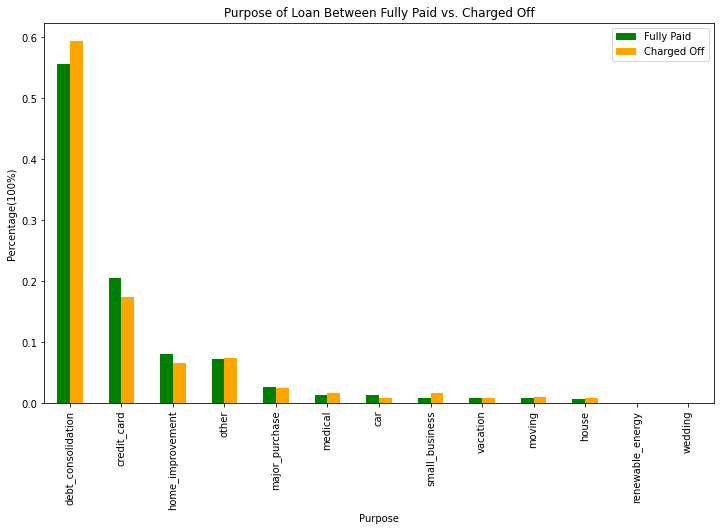

In [ ]:
pur.plot(x="purpose", y=["Fully Paid", "Charged Off"], kind="bar",figsize=(12,7),color={"Fully Paid": "green", "Charged Off": "orange"})
plt.xlabel('Purpose')
plt.ylabel('Percentage(100%)')
plt.title('Purpose of Loan Between Fully Paid vs. Charged Off')
plt.show()

# Fully Paid vs. Charged off : Grade 

In [ ]:
gr1=df_clean[df_clean['loan_status']=='Fully Paid']['grade'].value_counts(normalize=True).reset_index()
gr1.columns=['grade','Fully Paid']

In [ ]:
gr2=df_clean[df_clean['loan_status']=='Charged Off']['grade'].value_counts(normalize=True).reset_index()
gr2.columns=['grade','Charged Off']

In [ ]:
gr=pd.merge(gr1,gr2,on=['grade'])

In [ ]:
gr=gr.sort_values(by='grade')

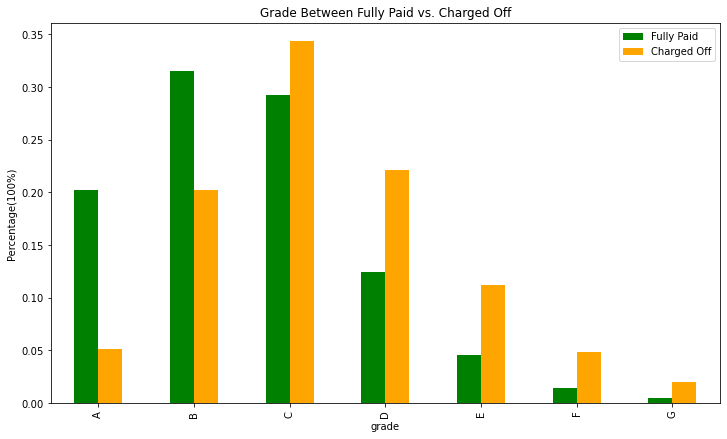

In [ ]:
gr.plot(x="grade", y=["Fully Paid", "Charged Off"], kind="bar",figsize=(12,7),color={"Fully Paid": "green", "Charged Off": "orange"})
plt.xlabel('grade')
plt.ylabel('Percentage(100%)')
plt.title('Grade Between Fully Paid vs. Charged Off')
plt.show()

# Average Interest by Loan Grade

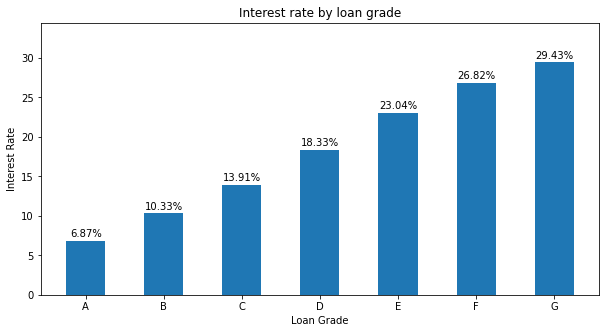

In [ ]:
def show_return_by_grade():
  """Bar plot to show loan average mean return by grade"""
  # Generating summary data for each grade
  return_by_grade, _, _ = split_data(df_clean)
  return_by_grade= return_by_grade[['grade','int_rate']]
  grouped_df = return_by_grade.groupby("grade")
  grouped_df = grouped_df.mean()
  grouped_df = grouped_df.reset_index()
  # Plotting interest rate bar chart for each loan grade
  plt.rcParams["figure.figsize"] = [10, 5]
  fig, ax = plt.subplots()
  pps = ax.bar(grouped_df['grade'], grouped_df['int_rate'], width=0.5, align='center')
  ax.set_ylim([0, grouped_df['int_rate'].max()+5])
  # Putting percentage value on top of each bar
  for p in pps:
    y = p.get_height()
    ax.text(x=p.get_x()+p.get_width()/2, y=y+0.5, s="{:.2f}%".format(y), ha='center')
  ax.set_title("Interest rate by loan grade")
  ax.set_ylabel("Interest Rate")
  ax.set_xlabel("Loan Grade")
  plt.show()

show_return_by_grade()

# Grade Distribution

In [ ]:
df_clean['grade'].value_counts()

C    149192
B    142033
A     82565
D     71836
E     29864
F     10710
G      4109
Name: grade, dtype: int64

In [ ]:
# grade distribution by number
df_clean.groupby(['loan_status','grade']).size()

loan_status  grade
Charged Off  A          5699
             B         22414
             C         38111
             D         24554
             E         12443
             F          5379
             G          2195
Fully Paid   A         76866
             B        119619
             C        111081
             D         47282
             E         17421
             F          5331
             G          1914
dtype: int64

In [ ]:
# grade distribution by percentage
sum_= df_clean.groupby(['loan_status','grade']).size()
# Change: groupby state_office and divide by sum
perc_ = sum_.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

In [ ]:
perc_

loan_status  grade
Charged Off  A        5.14
             B       20.23
             C       34.40
             D       22.16
             E       11.23
             F        4.85
             G        1.98
Fully Paid   A       20.25
             B       31.52
             C       29.27
             D       12.46
             E        4.59
             F        1.40
             G        0.50
dtype: float64

# Profit Perspective 

We generated Profit by multiplying 'term' and 'installment' and deducted 'loan_amnt' to find out the which loaner will give us higher profit .
We compared this profit by differet aspectives

In [ ]:
# First, we need to preprocess with term to get rid of strings
df_clean['term2']=df_clean['term'].str[0:3].astype(float)

In [ ]:
df_clean['term2'].head()

421101   36.00
421113   36.00
421120   36.00
421135   36.00
421137   60.00
Name: term2, dtype: float64

In [ ]:
# profit generation

In [ ]:
df_clean['profit']=(df_clean['installment']*df_clean['term2']) -df_clean['loan_amnt']

In [ ]:
#example 

In [ ]:
df_clean[['loan_amnt','term','int_rate','installment','grade','sub_grade','profit']]

,loan_amnt,term,int_rate,installment,grade,sub_grade,profit
421101,3000.00,36 months,7.34,93.10,A,A4,351.60
421113,5000.00,36 months,11.98,166.03,B,B5,977.08
421120,7000.00,36 months,11.98,232.44,B,B5,1367.84
421135,30000.00,36 months,21.85,1143.39,D,D5,11162.04
421137,21000.00,60 months,20.39,560.94,D,D4,12656.40
...,...,...,...,...,...,...,...
2260688,18000.00,60 months,9.49,377.95,B,B2,4677.00
2260690,29400.00,60 months,13.99,683.94,C,C3,11636.40
2260691,32000.00,60 months,14.49,752.74,C,C4,13164.40
2260692,16000.00,60 months,12.79,362.34,C,C1,5740.40


In [ ]:
#comparasion

In [ ]:
df_clean[(df_clean['sub_grade']=='D4')&(df_clean['loan_amnt']==40000)][['loan_amnt','term','int_rate','installment','grade','sub_grade','profit']]

,loan_amnt,term,int_rate,installment,grade,sub_grade,profit
437500,40000.00,60 months,20.39,1068.46,D,D4,24107.60
486712,40000.00,36 months,20.00,1486.55,D,D4,13515.80
501749,40000.00,60 months,20.00,1059.76,D,D4,23585.60
530683,40000.00,36 months,20.00,1486.55,D,D4,13515.80
538519,40000.00,60 months,20.00,1059.76,D,D4,23585.60
...,...,...,...,...,...,...,...
2161533,40000.00,60 months,19.99,1059.54,D,D4,23572.40
2174763,40000.00,36 months,19.99,1486.34,D,D4,13508.24
2194912,40000.00,60 months,19.99,1059.54,D,D4,23572.40
2233122,40000.00,60 months,19.99,1059.54,D,D4,23572.40


In [ ]:
df_clean[(df_clean['sub_grade']=='A1')&(df_clean['loan_amnt']==40000)][['loan_amnt','term','int_rate','installment','grade','sub_grade','profit']]

,loan_amnt,term,int_rate,installment,grade,sub_grade,profit
422352,40000.00,36 months,5.31,1204.42,A,A1,3359.12
423168,40000.00,36 months,5.31,1204.42,A,A1,3359.12
424998,40000.00,36 months,5.31,1204.42,A,A1,3359.12
425678,40000.00,36 months,5.31,1204.42,A,A1,3359.12
429574,40000.00,36 months,5.31,1204.42,A,A1,3359.12
...,...,...,...,...,...,...,...
2217733,40000.00,36 months,5.32,1204.60,A,A1,3365.60
2240308,40000.00,36 months,5.32,1204.60,A,A1,3365.60
2242965,40000.00,36 months,5.32,1204.60,A,A1,3365.60
2244830,40000.00,36 months,5.32,1204.60,A,A1,3365.60


In [ ]:
# average profit by type 
df_clean.groupby('loan_status')['margin'].sum()/df_clean['loan_status'].value_counts()

Charged Off   6039.82
Fully Paid    3867.21
dtype: float64

#  Profit by Grade Total 

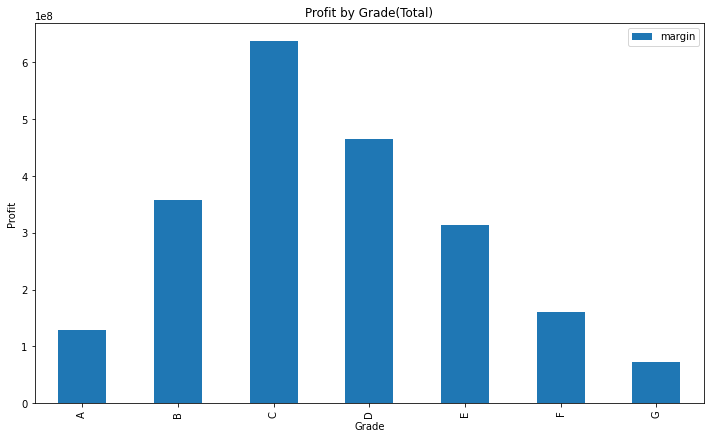

In [ ]:
profit.plot(x="grade", y=["margin"], kind="bar",figsize=(12,7))
plt.xlabel('Grade')
plt.ylabel('Profit')
plt.title('Profit by Grade(Total)')
plt.show()

#  Profit by Grade Charged off 

In [ ]:
profit2=df_clean[df_clean['loan_status']=='Charged Off'].groupby('grade')['margin'].sum().reset_index()

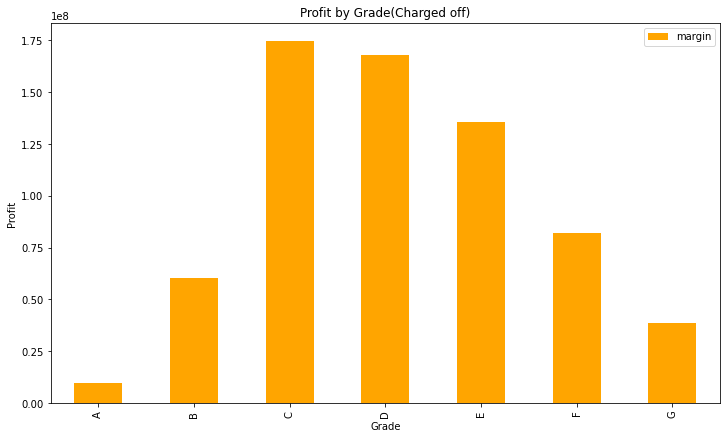

In [ ]:
profit2.plot(x="grade", y=["margin"], kind="bar",figsize=(12,7),color='orange')
plt.xlabel('Grade')
plt.ylabel('Profit')
plt.title('Profit by Grade(Charged off)')
plt.show()

In [ ]:
profit_full=df_clean[df_clean['loan_status']=='Fully Paid'].groupby('grade')['margin'].sum().reset_index()

In [ ]:
profit_full

,grade,margin
0,A,118558711.92
1,B,297999024.80
2,C,463710076.48
3,D,297586349.68
4,E,177539321.40
5,F,78473519.40
6,G,33792839.76


In [ ]:
#  Profit by Grade Fully Paid 

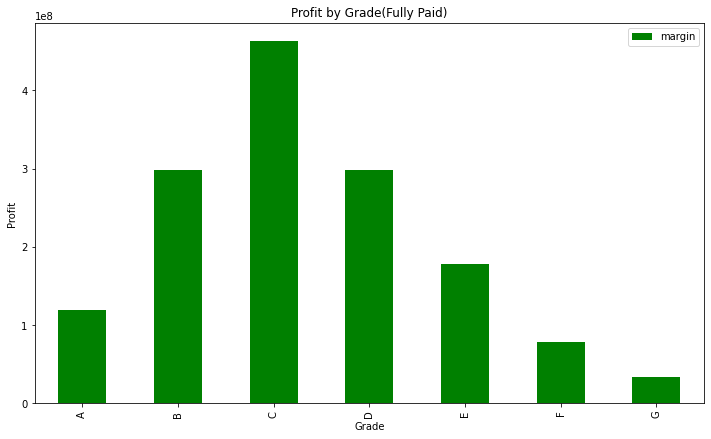

In [ ]:
profit_full.plot(x="grade", y=["margin"], kind="bar",figsize=(12,7),color='green')
plt.xlabel('Grade')
plt.ylabel('Profit')
plt.title('Profit by Grade(Fully Paid)')
plt.show()